In [1]:
import pandas as pd
import os
import time
import numpy as np
import torch

In [4]:
#! pip install dowhy
import dowhy.datasets

In [5]:
import seaborn as sns
from scipy import stats
from statistics import NormalDist
import matplotlib.pyplot as plt

In [6]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [7]:
from dowhy import CausalModel

In [8]:
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('CPU')
physical_devices = tf.config.list_physical_devices('GPU')

In [9]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [10]:
%matplotlib inline

# Confirmatory Causal Analysis
>
> Conformatory Experiments of Logits or Next Token Predictions @danaderp
>

In [11]:
def params( case = 2 ): 
    
    code_models = {
        'Case1':('EleutherAI/gpt-neo-125M','codesearch_tesbed_EleutherAI-gpt-neo-125M_10000.csv','EleutherAI-gpt-neo-125M_10000_','callbacks-EleutherAI-gpt-neo-125M_10000_'),
        'Case2':('EleutherAI/gpt-neo-2.7B','codesearch_tesbed_EleutherAI-gpt-neo-2.7B_10000.csv','EleutherAI-gpt-neo-2.7B_10000_','callbacks-EleutherAI-gpt-neo-2.7B_10000_'),    
        'Case3':('EleutherAI/gpt-neo-1.3B','codesearch_tesbed_EleutherAI-gpt-neo-1.3B_10000.csv','EleutherAI-gpt-neo-1.3B_10000_','callbacks-EleutherAI-gpt-neo-1.3B_10000_'),
        'Case4':('microsoft/CodeGPT-small-py','codesearch_tesbed_microsoft-CodeGPT-small-py_1024_10000.csv','CodeGPT-small-py_10000_','callbacks-CodeGPT-small-py_10000_'),
        'Case5':('microsoft/CodeGPT-small-py-adaptedGPT2','codesearch_tesbed_microsoft-CodeGPT-small-py-adaptedGPT2_1024_10000.csv','CodeGPT-small-py-adaptedGPT2_10000_','callbacks-CodeGPT-small-py-adaptedGPT2_10000_'),
        'Case6':('Salesforce/codegen-2B-multi','codesearch_tesbed_Salesforce-codegen-2B-multi_10000.csv','Salesforce-codegen-2B-multi_10000_','callbacks-Salesforce-codegen-2B-multi_10000_')
    }
    current_case = f'Case{case}' #<----[Hyper]
    
    #print(code_models[current_case][1])
    
    return {
            'big_table_path' : '../data/concept_tables/' + code_models[current_case][1],
            'hf_model' :  code_models[current_case][0],
            'model_name': code_models[current_case][2],
            'callbacks' : '../data/' + code_models[current_case][3],
            'wpe':2048,  #<----[Hyper] 1024 2048
            'outputs': '../datax/outputs/' + 'out_' + code_models[current_case][1]
        }   

In [12]:
#pwd TODO make the parameters iterable to load all the models at the same time
parameters = params()
parameters

{'big_table_path': '../data/concept_tables/codesearch_tesbed_EleutherAI-gpt-neo-2.7B_10000.csv',
 'hf_model': 'EleutherAI/gpt-neo-2.7B',
 'model_name': 'EleutherAI-gpt-neo-2.7B_10000_',
 'callbacks': '../data/callbacks-EleutherAI-gpt-neo-2.7B_10000_',
 'wpe': 2048,
 'outputs': '../datax/outputs/out_codesearch_tesbed_EleutherAI-gpt-neo-2.7B_10000.csv'}

# Data Upload

In [11]:
data_pd = pd.read_csv( parameters['outputs'] , index_col=0 )

FileNotFoundError: [Errno 2] No such file or directory: '../datax/outputs/out_codesearch_tesbed_EleutherAI-gpt-neo-2.7B_10000.csv'

In [32]:
data_pd.head(2)

,whole_func_string,ast_concepts,model_tokenizer_concepts,model_input_ids,model_total_input_ids,max_prob_case,min_prob_case,actual_prob_case,loss
0,"def encode_images(format_dict):\n """"""b64-en...","[('def', 'def', 'function_definition'), ('enco...","[(4299, 'def', 'function_definition'), (37773,...","[4299, 37773, 62, 17566, 7, 18982, 62, 11600, ...",355,"('module', 0.18295365571975708)","('ĠIncarn', 2.5102770068782115e-15)","[('Ġencode', 3.8248301279963925e-05), ('_', 0....",0.374540
1,"def _process_execute_error(self, msg):\n ...","[('def', 'def', 'function_definition'), ('_pro...","[(4299, 'def', 'function_definition'), (4808, ...","[4299, 4808, 14681, 62, 41049, 62, 18224, 7, 9...",398,"('module', 0.1829550713300705)","('ĠIncarn', 2.5107178875272574e-15)","[('Ġ_', 0.03443761542439461), ('process', 3.59...",0.950714


In [41]:
# Testing Block
def causal_data( ):
    data = dowhy.datasets.linear_dataset(
        beta=2,
        num_common_causes=20,
        num_instruments=0,
        num_samples=10000,
        treatment_is_binary=False,
        stddev_treatment_noise = 10 )
    
    return data

In [42]:
data = {f'model{m}' :causal_data() for m in range(2)}

In [43]:
data['model0']['df']

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,...,W12,W13,W14,W15,W16,W17,W18,W19,v0,y
0,0.828229,0.423555,-0.831111,0.630135,-0.564743,-0.112334,0.268035,-0.286035,0.703469,-0.447177,...,1.352955,-0.335035,-0.727994,0.054215,-0.631102,-0.890381,-0.053060,-0.994420,-7.129064,-17.864173
1,0.129062,-0.515504,-0.028622,0.162797,-2.439382,1.756637,0.037569,1.424478,1.287867,-0.158763,...,-2.115484,0.815806,-0.474962,-1.296279,-0.148967,3.020056,-1.430199,0.191810,2.195935,3.508201
2,1.789739,-1.719466,-0.551978,0.567596,-1.841545,0.749299,0.345107,-1.036109,-0.779412,-1.697454,...,-2.127816,-0.160586,-1.268097,1.612204,0.121526,-0.612916,-0.365909,-1.061503,-4.517874,-11.731428
3,-1.065037,1.722514,-0.089998,0.110619,-1.433356,2.404647,1.191089,0.943436,0.256949,0.972528,...,0.210309,-0.553429,-0.401284,-1.096071,-0.693859,2.866840,0.339699,0.454561,6.002933,11.702958
4,0.962058,1.817964,-1.042115,-0.744647,-1.583888,0.578541,0.576314,-0.964756,-1.098201,-0.558562,...,-1.256202,-0.487567,1.730861,-0.344256,0.344042,2.757356,0.808489,1.444304,-20.849325,-39.351866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.324911,0.640566,0.049320,0.599192,-2.429132,-0.712933,0.944570,-0.086247,2.550978,-0.985028,...,-2.301432,1.086176,0.556131,-0.574001,-0.756501,0.213150,-0.550025,-0.306292,-1.374188,-2.224192
9996,0.764116,1.448424,-0.014935,0.339706,-2.761285,1.078779,-0.374756,-1.137691,1.179906,0.697964,...,-3.116300,0.771873,-1.811501,-0.556784,0.742225,-0.898653,-0.089062,-0.825703,-19.677312,-42.601155
9997,0.198685,-0.036371,-1.218242,1.260358,-2.513815,-0.236090,2.328481,-0.777506,-0.419755,0.142952,...,-2.385007,0.212966,-0.342589,-0.420417,-1.590305,1.331138,-1.423419,1.349137,-25.273097,-54.673835
9998,0.442998,-0.923597,-1.854550,2.177653,-1.277326,1.332261,0.139336,-0.737731,0.185375,-0.195563,...,-1.126174,-1.944623,0.461574,-1.267779,1.249548,0.761262,-0.533042,-0.397509,2.635552,3.014308


In [44]:
data['model0']['df'].describe() #TODO use this matrix to compute correlations and causations

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,...,W12,W13,W14,W15,W16,W17,W18,W19,v0,y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.922551,0.258637,-0.365426,0.523952,-0.883544,0.050497,0.157327,-0.075558,0.616774,-0.234486,...,-0.709996,0.432129,-0.004574,-0.189283,0.272578,0.827346,-0.668795,0.231681,0.291361,2.873353
std,1.005903,1.002402,0.996599,0.987363,1.005060,1.010745,1.003568,0.990025,0.993993,1.009311,...,0.996972,1.002787,0.991918,0.986674,1.007775,0.989308,0.997402,0.993977,10.654258,22.965295
min,-2.969988,-3.444292,-4.130492,-3.459236,-4.373466,-3.738108,-3.857369,-3.669247,-2.711531,-4.461862,...,-4.532111,-3.245786,-4.701177,-3.508899,-3.105499,-3.171547,-4.589953,-3.341834,-38.586233,-87.236189
25%,0.233511,-0.408962,-1.033391,-0.133303,-1.555060,-0.642170,-0.519863,-0.750770,-0.048630,-0.920060,...,-1.380481,-0.245954,-0.671394,-0.858522,-0.400068,0.160763,-1.342881,-0.453840,-6.875354,-12.591010
50%,0.940125,0.246156,-0.391521,0.535726,-0.899540,0.039444,0.157897,-0.069988,0.610681,-0.234227,...,-0.714914,0.438162,-0.006374,-0.190479,0.277220,0.838619,-0.673922,0.231919,0.274083,2.936213
75%,1.608092,0.931632,0.321962,1.192468,-0.213651,0.740617,0.843693,0.589490,1.297078,0.447543,...,-0.036859,1.121501,0.662591,0.489432,0.949707,1.496689,0.008034,0.918378,7.464101,18.310122
max,4.980613,3.992516,3.647719,4.172109,2.510855,4.009963,3.573629,3.396697,4.318340,3.824764,...,2.793938,4.655711,3.848094,3.721505,3.828642,4.627157,3.393079,4.126767,40.698306,90.076405


## Correlation Analysis

In [19]:
sns.set_theme(style="darkgrid")

<AxesSubplot:ylabel='Frequency'>

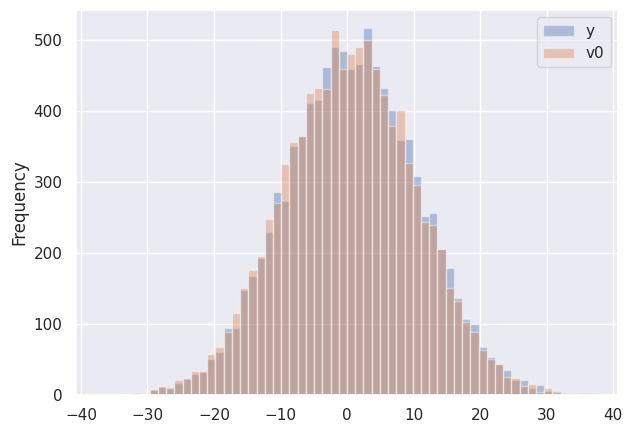

In [20]:
data['model0']['df'][['y','v0']].plot.hist(
    bins=60, 
    alpha=0.4,
    figsize=(7,5)
)


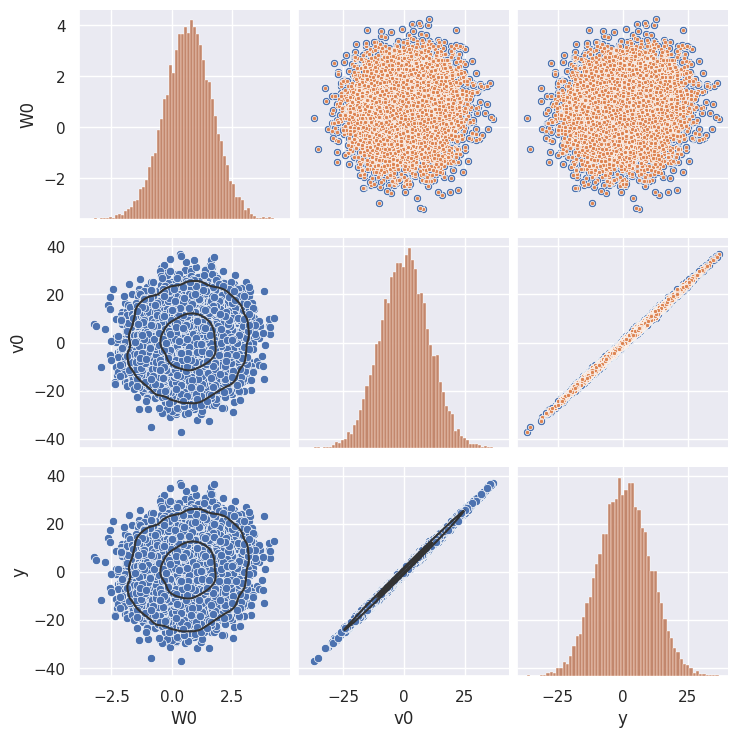

In [30]:
#Check here: https://seaborn.pydata.org/generated/seaborn.pairplot.html
g = sns.pairplot(data=data['model0']['df'])
g.map_upper(sns.scatterplot,marker=".")
g.map_lower(sns.kdeplot,levels=3,color=".2")
g.map_diag(sns.histplot)

<AxesSubplot:xlabel='v0', ylabel='y'>

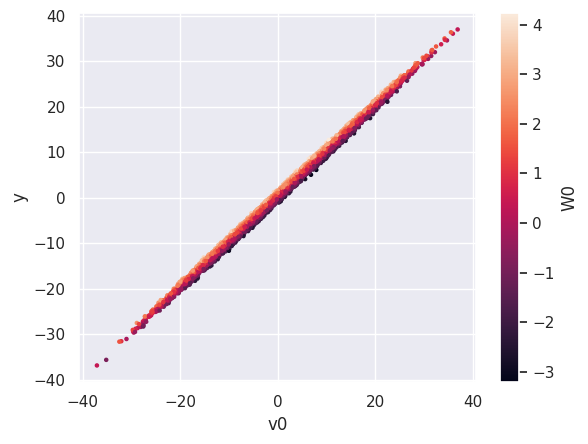

In [37]:
data['model0']['df'].plot.scatter(
    x = 'v0',
    y = 'y',
    c = 'W0', #Common Causes
    s = 5
)

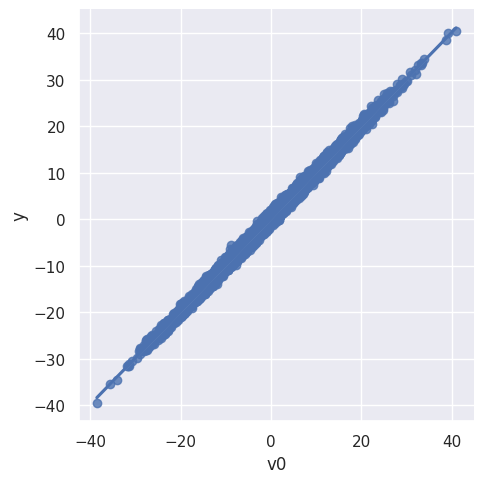

In [18]:
#Check here for more plots: https://seaborn.pydata.org/tutorial/regression.html
#g = sns.relplot(data=data['df'], x="v0", y="y")
g = sns.lmplot(
    data=data['df'], 
    x="v0", 
    y="y",
    #x_estimator=np.mean
    #logistic=True
    );

In [19]:
corr, p_val = stats.pearsonr(data['df']["v0"], data['df']["y"])
logging.info( f"correlation:{corr} pval:{p_val}" )

2023-02-24 04:00:02,669 : INFO : correlation:0.9978487625807155 pval:0.0


In [20]:
corr, p_val = stats.pearsonr(data['df']["y"], data['df']["W0"])
logging.info( f"correlation:{corr} pval:{p_val}" )

2023-02-24 04:00:04,166 : INFO : correlation:0.05528425085648883 pval:3.166636329225156e-08


## Causal Analysis

In [21]:
# I. Create a causal model from the data and given graph.
causal_model = CausalModel(
    data=data["df"],
    treatment=['v0'],
    outcome=['y'],
    common_causes=["W1"]
    #instruments=data["instrument_names"]
    )

2023-02-24 04:00:09,355 : WARNING : Causal Graph not provided. DoWhy will construct a graph based on data inputs.
2023-02-24 04:00:09,357 : INFO : Model to find the causal effect of treatment ['v0'] on outcome ['y']


In [25]:
# II. Identify causal effect and return target estimands
identified_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)
logging.info(identified_estimand)

2023-02-24 04:00:40,584 : INFO : Causal effect can be identified.
2023-02-24 04:00:40,588 : INFO : Instrumental variables for treatment and outcome:[]
2023-02-24 04:00:40,589 : INFO : Frontdoor variables for treatment and outcome:[]
2023-02-24 04:00:40,590 : INFO : Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d           
─────(E[y|W1])
d[v₀]         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,U) = P(y|v0,W1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [27]:
# III. Estimate the target estimand using a statistical method.
propensity_strat_estimate = causal_model.estimate_effect(identified_estimand,
                                 method_name="backdoor.dowhy.linear_regression")

print(propensity_strat_estimate)

2023-02-24 04:01:41,143 : INFO : INFO: Using Linear Regression Estimator
2023-02-24 04:01:41,149 : INFO : b: y~v0+W1


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d           
─────(E[y|W1])
d[v₀]         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,U) = P(y|v0,W1)

## Realized estimand
b: y~v0+W1
Target units: ate

## Estimate
Mean value: 0.9998761321498759



In [24]:
# IV. Refute the obtained estimate using multiple robustness checks.
refute_results = causal_model.refute_estimate(identified_estimand, propensity_strat_estimate,
                                       method_name="placebo_treatment_refuter")
print(refute_results)

2023-02-24 04:00:17,051 : INFO : Refutation over 100 simulated datasets of PlaceboType.DEFAULT treatment
2023-02-24 04:00:17,057 : INFO : Using a Normal Distribution with Mean:0 and Variance:0
2023-02-24 04:00:17,064 : INFO : b: y~placebo+W1
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
2023-02-24 04:00:17,089 : INFO : Using a Normal Distribution with Mean:0 and Variance:0
2023-02-24 04:00:17,094 : INFO : b: y~placebo+W1
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
2023-02-24 04:00:17,117 : INFO : Using a Normal Distribution with Mean:0 and Variance:0
2023-02-24 04:00:17,122 : INFO : b: y~placebo+W1
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by ze

Refute: Use a Placebo Treatment
Estimated effect:0.9998761321498759
New effect:0.0
p value:2.0



In [177]:
child_logits = {}
parent_logits = {}

for i,sequence in enumerate( data_pd.actual_prob_case.values ):
    #print(sequence)
    tok_tuple_list = eval( data_pd.model_tokenizer_concepts.values[i] )
    for j,label_tuple in enumerate( tok_tuple_list[1:] ): #Dropping first token
        if label_tuple[1] in set( child_logits.keys() ):
            #print('in',label_tuple,sequence[j])
            child_logits[label_tuple[1]].append( sequence[j][1] )
        else:
            #print('out',label_tuple,sequence[j])
            child_logits[label_tuple[1]] = []
            child_logits[label_tuple[1]].append( sequence[j][1] )
            
        ### PARENT
        if label_tuple[1] in set( parent_logits.keys() ):
            #print('in',label_tuple,sequence[j])
            parent_logits[label_tuple[2]].append( sequence[j][1] )
        else:
            #print('out',label_tuple,sequence[j])
            parent_logits[label_tuple[2]] = []
            parent_logits[label_tuple[2]].append( sequence[j][1] )

In [253]:
parent_logits['function_definition']

[tensor(4.9403e-07, grad_fn=<SelectBackward0>)]

In [185]:
parent_logits.keys()

dict_keys(['function_definition', 'parameters', 'default_parameter', 'ERROR', 'expression_statement', 'if_statement', 'comparison_operator', 'raise_statement', 'call', 'argument_list', 'attribute', 'assignment', 'binary_operator', 'return_statement', 'global_statement', 'block', 'try_statement', 'lambda', 'lambda_parameters', 'not_operator', 'boolean_operator', 'dictionary', 'subscript', 'elif_clause', 'pass_statement', 'finally_clause', 'for_statement', 'keyword_argument', 'pair', 'dictionary_comprehension', 'for_in_clause', 'pattern_list', 'if_clause', 'list_splat_pattern', 'augmented_assignment', 'parenthesized_expression', 'tuple', 'else_clause', 'list', 'slice', 'list_comprehension', 'except_clause', 'unary_operator', 'yield', 'import_from_statement', 'dotted_name', 'dictionary_splat_pattern', 'tuple_pattern', 'list_splat', 'dictionary_splat', 'with_statement', 'as_pattern', 'as_pattern_target', 'conditional_expression', 'concatenated_string', 'generator_expression', 'expression_l

In [197]:
[ (elem,np.mean( [np_elem.detach().numpy() for np_elem in parent_logits[elem] ] )) for elem in parent_logits.keys()]

[('function_definition', 4.9402684e-07),
 ('parameters', 0.45352417),
 ('default_parameter', 0.49697953),
 ('ERROR', 0.96551734),
 ('expression_statement', 0.96332645),
 ('if_statement', 0.35947895),
 ('comparison_operator', 0.49701786),
 ('raise_statement', 0.5022117),
 ('call', 0.09397892),
 ('argument_list', 0.9793428),
 ('attribute', 0.55561125),
 ('assignment', 0.9822823),
 ('binary_operator', 0.93023354),
 ('return_statement', 0.062402897),
 ('global_statement', 0.12389463),
 ('block', 0.04229165),
 ('try_statement', 0.9985191),
 ('lambda', 0.8635597),
 ('lambda_parameters', 0.9691714),
 ('not_operator', 0.99964225),
 ('boolean_operator', 0.29123697),
 ('dictionary', 0.7888982),
 ('subscript', 0.95072013),
 ('elif_clause', 0.5141071),
 ('pass_statement', 0.15036604),
 ('finally_clause', 0.99995124),
 ('for_statement', 0.9405241),
 ('keyword_argument', 0.9812852),
 ('pair', 0.874644),
 ('dictionary_comprehension', 0.6176669),
 ('for_in_clause', 0.9983662),
 ('pattern_list', 0.0209

In [199]:
[ (elem,np.mean( [np_elem.detach().numpy() for np_elem in child_logits[elem] ] )) for elem in child_logits.keys()]

[('identifier', 0.5504931),
 ('(', 0.6492624),
 (',', 0.6478024),
 ('=', 0.73198533),
 ('false', 0.42686236),
 (')', 0.62872636),
 ('ERROR', 0.96551734),
 ('string', 0.621419),
 ('if', 0.2772697),
 ('not', 0.22935918),
 ('in', 0.82017523),
 (':', 0.8133965),
 ('raise', 0.5658),
 ('+', 0.41851243),
 ('return', 0.41479897),
 ('global', 0.06456195),
 ('.', 0.7721778),
 ('float', 0.42957017),
 ('*', 0.2961083),
 ('none', 0.673475),
 ('comment', 0.31376114),
 ('try', 0.027253374),
 ('true', 0.62086904),
 ('lambda', 0.58812237),
 ('or', 0.110503495),
 ('}', 0.5254813),
 ('[', 0.5780259),
 ('elif', 0.55802226),
 ('pass', 0.17900899),
 ('finally', 0.07824747),
 ('for', 0.45117524),
 ('integer', 0.48820278),
 ('-', 0.32622436),
 ('{', 0.17415868),
 ('%', 0.84188503),
 (']', 0.6644342),
 ('|=', 0.5004129),
 ('&', 0.6276737),
 ('is', 0.6191611),
 ('else', 0.5030283),
 ('<', 0.29024956),
 ('and', 0.19557978),
 ('>', 0.20081393),
 ('except', 0.73677486),
 ('==', 0.43423653),
 ('def', 0.15680842),
 

## Bootstrapping 

In [203]:
#export
def bootstrapping( np_data, np_func, size ):
    """Create a bootstrap sample given data and a function
    For instance, a bootstrap sample of means, or mediands. 
    The bootstrap replicates are a long as the original size
    we can choose any observation more than once (resampling with replacement:np.random.choice)
    """
    
    #Cleaning NaNs
    #np_data_clean = np_data[ np.logical_not( np.isnan(np_data) ) ] 
    
    #The size of the bootstrap replicate is as big as size
    #Creating the boostrap replicates as long as the orignal data size
    #This strategy might work as imputation 
    bootstrap_repl = [ np_func( np.random.choice( np_data, size=len(np_data) ) ) for i in range( size ) ]
    
    #logging.info("Covariate: " + cov) #Empirical Mean
    #logging.info("Empirical Mean: " + str(np.mean(np_data_clean))) #Empirical Mean
    #logging.info("Bootstrapped Mean: " + str( np.mean(bootstrap_repl) ) ) #Bootstrapped Mean
    
    return np.array( bootstrap_repl )

In [212]:
def dictionary_boots( dict_concepts, np_func = np.mean, size=500):
    np_dettached = lambda np_ccp: np.array([ np_elem.detach().numpy() for np_elem in np_ccp ]).flatten()
    return {ccp: bootstrapping(np_dettached( dict_concepts[ccp] ), np_func, size) for ccp in dict_concepts.keys()}

In [213]:
dict_test = dictionary_boots(
    dict_concepts = parent_logits
)

In [234]:
pd_test_bs = pd.DataFrame.from_dict( dict_test )

In [235]:
pd_test_bs.head()

,function_definition,parameters,default_parameter,ERROR,expression_statement,if_statement,comparison_operator,raise_statement,call,argument_list,...,expression_list,typed_default_parameter,type,while_statement,import_statement,aliased_import,class_definition,continue_statement,set_comprehension,assert_statement
0,4.940268e-07,0.453524,0.49698,0.963887,0.963326,0.359479,0.497018,0.502212,0.093979,0.979343,...,0.999519,0.066759,0.336859,0.531041,0.255988,0.000065,0.995736,0.269588,0.878069,0.003569
1,4.940268e-07,0.453524,0.49698,0.964926,0.963326,0.359479,0.497018,0.502212,0.093979,0.979343,...,0.999519,0.066759,0.336859,0.531041,0.255988,0.000065,0.995736,0.269588,0.878069,0.003569
2,4.940268e-07,0.453524,0.49698,0.965100,0.963326,0.359479,0.497018,0.502212,0.093979,0.979343,...,0.999519,0.066759,0.336859,0.531041,0.255988,0.000065,0.995736,0.269588,0.878069,0.003569
3,4.940268e-07,0.453524,0.49698,0.966258,0.963326,0.359479,0.497018,0.502212,0.093979,0.979343,...,0.999519,0.066759,0.336859,0.531041,0.255988,0.000065,0.995736,0.269588,0.878069,0.003569
4,4.940268e-07,0.453524,0.49698,0.965908,0.963326,0.359479,0.497018,0.502212,0.093979,0.979343,...,0.999519,0.066759,0.336859,0.531041,0.255988,0.000065,0.995736,0.269588,0.878069,0.003569


In [251]:
pd_test_bs.describe()

,function_definition,parameters,default_parameter,ERROR,expression_statement,if_statement,comparison_operator,raise_statement,call,argument_list,...,expression_list,typed_default_parameter,type,while_statement,import_statement,aliased_import,class_definition,continue_statement,set_comprehension,assert_statement
count,5.000000e+02,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,4.940268e-07,0.453524,0.49698,0.965559,0.963326,0.359479,0.497018,0.502212,0.093979,0.979343,...,0.999519,0.066759,0.336859,0.531041,0.255989,0.000065,0.995736,0.269588,0.878069,0.003569
std,0.000000e+00,0.000000,0.00000,0.001098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,4.940268e-07,0.453524,0.49698,0.961945,0.963326,0.359479,0.497018,0.502212,0.093979,0.979343,...,0.999519,0.066759,0.336859,0.531041,0.255988,0.000065,0.995736,0.269588,0.878069,0.003569
25%,4.940268e-07,0.453524,0.49698,0.964908,0.963326,0.359479,0.497018,0.502212,0.093979,0.979343,...,0.999519,0.066759,0.336859,0.531041,0.255988,0.000065,0.995736,0.269588,0.878069,0.003569
50%,4.940268e-07,0.453524,0.49698,0.965573,0.963326,0.359479,0.497018,0.502212,0.093979,0.979343,...,0.999519,0.066759,0.336859,0.531041,0.255988,0.000065,0.995736,0.269588,0.878069,0.003569
75%,4.940268e-07,0.453524,0.49698,0.966248,0.963326,0.359479,0.497018,0.502212,0.093979,0.979343,...,0.999519,0.066759,0.336859,0.531041,0.255988,0.000065,0.995736,0.269588,0.878069,0.003569
max,4.940268e-07,0.453524,0.49698,0.969271,0.963326,0.359479,0.497018,0.502212,0.093979,0.979343,...,0.999519,0.066759,0.336859,0.531041,0.255988,0.000065,0.995736,0.269588,0.878069,0.003569


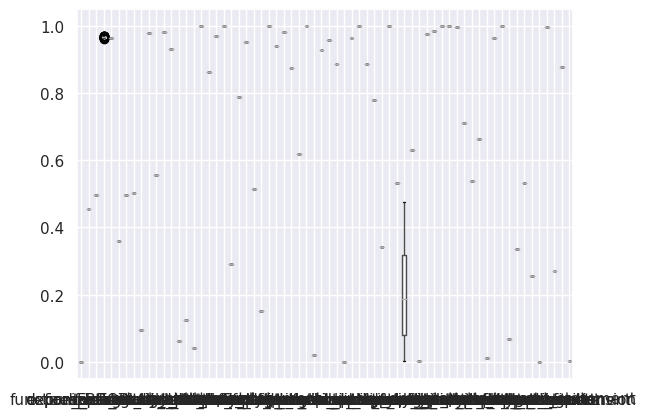

In [254]:
sns.set_theme(style="darkgrid")
boxplot = pd_test_bs.boxplot()
plt.show()

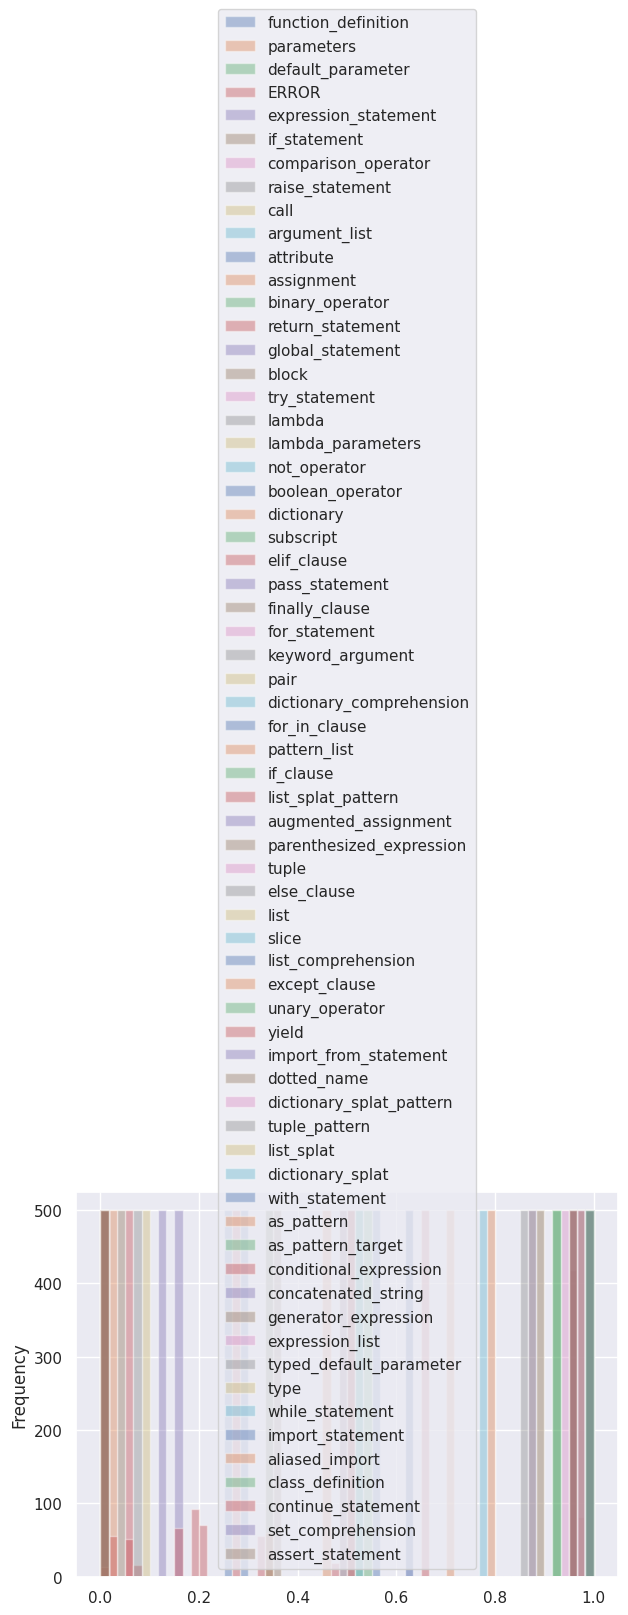

In [250]:
sns.set_theme(style="darkgrid")
#ax = pd_test_bs.plot.kde()
pd_test_bs.plot.hist(
    bins=60, 
    alpha=0.4,
    figsize=(7,5)
)
plt.show()

In [218]:
assert len(dict_test['function_definition']) == len(dict_test['argument_list']) 

In [226]:
#export
#We use normal distribution assuming the sample size is big enough (~more than 100 points)
def confidence_intervals_v1(np_data_bs, conf=0.95):
    """Confidence Intervals with Gaussian Distribution (n>=30)"""
    CI = stats.norm.interval(alpha=conf, loc = np.mean( np_data_bs ), scale = stats.sem(np_data_bs))
    return CI

In [231]:
#export
#see https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def confidence_intervals_v2(data, confidence=0.95):
    dist = NormalDist.from_samples(data)
    z = NormalDist().inv_cdf((1 + confidence) / 2.)
    h = dist.stdev * z / ((len(data) - 1) ** .5)
    return dist.mean - h, dist.mean + h, h

In [232]:
dict_test_intervals = {k: confidence_intervals_v2(dict_test[k]) for k in dict_test.keys() }

In [233]:
dict_test_intervals

{'function_definition': (4.940268354403088e-07, 4.940268354403088e-07, 0.0),
 'parameters': (0.4535241723060608, 0.4535241723060608, 0.0),
 'default_parameter': (0.4969795346260071, 0.4969795346260071, 0.0),
 'ERROR': (0.965463052576959, 0.9656556741533877, 9.631078821433487e-05),
 'expression_statement': (0.9633264541625977, 0.9633264541625977, 0.0),
 'if_statement': (0.3594789505004883, 0.3594789505004883, 0.0),
 'comparison_operator': (0.49701786041259766, 0.49701786041259766, 0.0),
 'raise_statement': (0.5022116899490356, 0.5022116899490356, 0.0),
 'call': (0.09397891908884048, 0.09397891908884048, 0.0),
 'argument_list': (0.9793428182601929, 0.9793428182601929, 0.0),
 'attribute': (0.555611252784729, 0.555611252784729, 0.0),
 'assignment': (0.982282280921936, 0.982282280921936, 0.0),
 'binary_operator': (0.9302335381507874, 0.9302335381507874, 0.0),
 'return_statement': (0.06240289658308029, 0.06240289658308029, 0.0),
 'global_statement': (0.12389463186264038, 0.12389463186264038,